<a href="https://colab.research.google.com/github/lisatwyw/data-gym/blob/master/WISDM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview #

- This is a notebook prepared for you to try out classification tasks using time-series data acquired using accelerometers of iPhone's.

- You'll get to:
 - train a model based on neural networks 
 - learn about ```CoreML```
 
- Post-demo exercise: try to replicate below using the [Actitracker dataset](http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_at_latest.tar.gz)

# A) Mount Google drive #


In [0]:
from google.colab import drive
drive.mount('/content/drive')

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# B) Create subfolder ``wisdm`` in your ```opensource_datasets``` folder #

In [0]:
try:
  ! mkdir '/content/drive/My Drive/Colab Notebooks/opensource_datasets/'
except e as Exception:
  pass  
import os
try:
  ! mkdir '/content/drive/My Drive/Colab Notebooks/opensource_datasets/wisdm'
except e as Exception:
  pass  
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/opensource_datasets/wisdm')

mkdir: cannot create directory ‘/content/drive/My Drive/Colab Notebooks/opensource_datasets/’: File exists


# C) Download from website and unzip contents ##

In [0]:
try:
  ! wget -O wisdm.gz http://www.cis.fordham.edu/wisdm/includes/datasets/latest/WISDM_ar_latest.tar.gz
  ! tar -xf wisdm.gz
  print('done unzipping')
except:
  pass

! ls

done
WISDM_ar_v1.1  wisdm.gz


# D) Run the following demo code written by [Nils Ackermann](https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0?)# 

In [0]:
import numpy as np
import pandas as pd

# https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0?

def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))

# Load data set containing all the data from csv
df = read_data('WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt')


## Examine the data ##

In [0]:
df.head(5)

,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


## Prepare the output labels ##

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing


# Set some standard parameters upfront
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel


plt.style.use('ggplot')

# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']


# The number of steps within one time segment
TIME_PERIODS = 80

# The steps to take from one segment to the next; if this value is equal to TIME_PERIODS, then there is no overlap between the segments
STEP_DISTANCE = 40


# Define column name of the label vector
LABEL = 'ActivityEncoded'
# Transform the labels from String to Integer via LabelEncoder

le = preprocessing.LabelEncoder()
# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

num_classes = le.classes_.size
print(list(le.classes_))

## Split the dataset into training and test subsets ##

In [0]:
pd.options.mode.chained_assignment = None  # default='warn'

df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]


## Normalize the input data ##

In [0]:
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()

# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [0]:
import keras
print('keras version ', keras.__version__)


keras version  2.2.5


## Install library ```coreML``` not already available ##

In [0]:
! pip install coremltools
import coremltools

     |████████████████████████████████| 3.4MB 4.8MB/s 


## Prepare the training dataset ##

In [0]:
from scipy import stats
from keras.utils import np_utils


def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

# convert to float
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

# convert output labels using one-hot-encoding
y_train_hot = np_utils.to_categorical(y_train, num_classes)


In [0]:
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
print( 'Input data:', x_train.shape, '\n3 time-series and 80 timepoints; total of', y_train.shape, 'samples' )

input_shape = (num_time_periods*num_sensors)



x_train = x_train.reshape(x_train.shape[0], input_shape)

print('After reshaping, x_train has shape', x_train.shape)
print('input_shape:', input_shape)

IndexError: ignored

## Construct the model ##

In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Reshape
from keras.layers import Conv2D, MaxPooling2D


model_m = Sequential()
# Remark: since coreml cannot accept vector shapes of complex shape like
# [80,3] this workaround is used in order to reshape the vector internally
# prior feeding it into the network
model_m.add(Reshape((TIME_PERIODS, 3), input_shape=(input_shape,)))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Dense(100, activation='relu'))
model_m.add(Flatten())
model_m.add(Dense(num_classes, activation='softmax'))
print(model_m.summary())


x_train shape: (20868, 240)
input_shape: 240



Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 80, 100)           400       
_________________________________________________________________
dense_2 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
dense_3 (Dense)              (None, 80, 100)           10100     
_________________________________________________________________
flatten_1 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 48006     
Total params: 68,606
Trainable params: 68,606
Non-trainable params: 0
__________________________________________________

## Train it! ##

In [0]:
callbacks_list = [
    keras.callbacks.ModelCheckpoint(
        filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    keras.callbacks.EarlyStopping(monitor='acc', patience=1)
]

model_m.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

# Hyper-parameters
BATCH_SIZE = 400
EPOCHS = 50

# Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
history = model_m.fit(x_train,
                      y_train_hot,
                      batch_size=BATCH_SIZE,
                      epochs=EPOCHS,
                      callbacks=callbacks_list,
                      validation_split=0.2,
                      verbose=1)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 16694 samples, validate on 4174 samples
Epoch 1/50



16694/16694 [==============================] - 7s 441us/step - loss: 1.0939 - acc: 0.6349 - val_loss: 0.7461 - val_acc: 0.8002
Epoch 2/50
16694/16694 [==============================] - 7s 396us/step - loss: 0.6100 - acc: 0.7852 - val_loss: 0.6375 - val_acc: 0.8131
Epoch 3/50
16694/16694 [==============================] - 7s 402us/step - loss: 0.5232 - acc: 0.8090 - val_loss: 0.6111 - val_acc: 0.8349
Epoch 4/50
16694/16694 [==============================] - 7s 401us/step - loss: 0.4909 - acc: 0.8206 - val_loss: 0.6107 - val_acc: 0.8265
Epoch 5/50
16694/16694 [==============================] - 7s 402us/step - loss: 0.4681 - acc: 0.8287 - val_loss: 0.6268 - val_acc: 0.8354
Epoch 6/50
16694/16694 [==============================] - 7s 406us/step - loss: 0.4525 - acc: 0.8346 - val_loss: 0.6449 - val_acc: 0.7990
Epoch 7/50
16694/16694 [==============================] - 7s 402us/step - loss: 0.4293 - acc: 0.8446 - val_loss: 0.6934 - val_acc: 0.7559
Epoch 8/50
16694/16694 [=====================

## Examine the training progress and evaluate the trained model ##

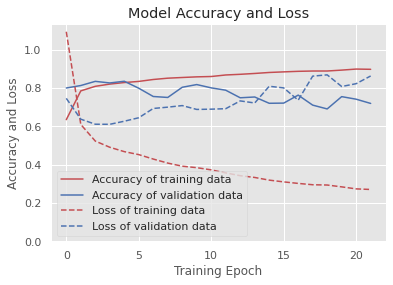

              precision    recall  f1-score   support

         0.0       0.63      0.49      0.55      1864
         1.0       0.98      0.98      0.98      6567
         2.0       0.99      0.99      0.99      1050
         3.0       0.99      0.99      0.99       833
         4.0       0.61      0.69      0.64      2342
         5.0       0.89      0.89      0.89      8212

    accuracy                           0.87     20868
   macro avg       0.85      0.84      0.84     20868
weighted avg       0.87      0.87      0.87     20868



In [0]:
plt.figure(figsize=(6, 4))
plt.plot(history.history['acc'], 'r', label='Accuracy of training data')
plt.plot(history.history['val_acc'], 'b', label='Accuracy of validation data')
plt.plot(history.history['loss'], 'r--', label='Loss of training data')
plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
plt.title('Model Accuracy and Loss')
plt.ylabel('Accuracy and Loss')
plt.xlabel('Training Epoch')
plt.ylim(0)
plt.legend()
plt.show()

# Print confusion matrix for training data
y_pred_train = model_m.predict(x_train)
# Take the class with the highest probability from the train predictions
max_y_pred_train = np.argmax(y_pred_train, axis=1)


from sklearn.metrics import classification_report
print(classification_report(y_train, max_y_pred_train))

## Prepare the test subset ##

In [0]:
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

# Round numbers
df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels( df_test,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)
# convert to float
x_test = x_test.astype('float32')
y_test = y_test.astype('float32')



# convert output labels using one-hot-encoding
y_test_hot = np_utils.to_categorical(y_test, num_classes)


In [0]:
y_test.shape

(6584,)

## Evaluate the model on the test set and report results with a confusion matrix ##

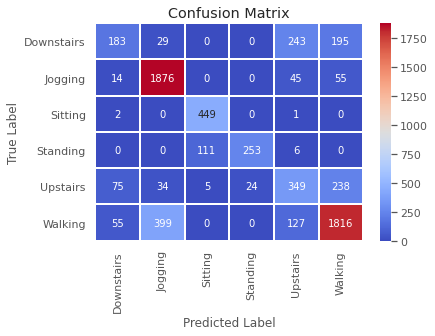

              precision    recall  f1-score   support

         0.0       0.56      0.28      0.37       650
         1.0       0.80      0.94      0.87      1990
         2.0       0.79      0.99      0.88       452
         3.0       0.91      0.68      0.78       370
         4.0       0.45      0.48      0.47       725
         5.0       0.79      0.76      0.77      2397

    accuracy                           0.75      6584
   macro avg       0.72      0.69      0.69      6584
weighted avg       0.74      0.75      0.74      6584



In [0]:
x_test = x_test.reshape(x_test.shape[0], input_shape)

y_pred_test = model_m.predict(x_test)

# Take the class with the highest probability from the test predictions
max_y_pred_test = np.argmax(y_pred_test, axis=1)



import seaborn as sns  # ! pip install seaborn
import matplotlib.pyplot as plt
from sklearn import metrics

def show_confusion_matrix(validations, predictions, LABELS ):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# y_test, max_y_pred_test are (nSamples,1), LABELS is a list of the classes, indexed from 0 up to num_classes-1
show_confusion_matrix(y_test, max_y_pred_test, LABELS )

print(classification_report(y_test, max_y_pred_test))

## Export to CoreML file ##

In [0]:
coreml_model = coremltools.converters.keras.convert(model_m,
                                                    input_names=['acceleration'],
                                                    output_names=['output'],
                                                    class_labels=LABELS)

print(coreml_model)
coreml_model.author = 'Nils Ackermann'
coreml_model.license = 'N/A'
coreml_model.short_description = 'Activity based recognition based on WISDM dataset'
coreml_model.output_description['output'] = 'Probability of each activity'
coreml_model.output_description['classLabel'] = 'Labels of activity'

coreml_model.save('HARClassifier.mlmodel')

0 : reshape_1_input, <keras.engine.input_layer.InputLayer object at 0x7fec4b8304e0>
1 : reshape_1, <keras.layers.core.Reshape object at 0x7fec4b830470>
2 : dense_1, <keras.layers.core.Dense object at 0x7fec4b8446a0>
3 : dense_1__activation__, <keras.layers.core.Activation object at 0x7fec432126a0>
4 : dense_2, <keras.layers.core.Dense object at 0x7fec4b830978>
5 : dense_2__activation__, <keras.layers.core.Activation object at 0x7fec4568b748>
6 : dense_3, <keras.layers.core.Dense object at 0x7fec4b830a58>
7 : dense_3__activation__, <keras.layers.core.Activation object at 0x7fec432127f0>
8 : flatten_1, <keras.layers.core.Flatten object at 0x7fec4b7eaef0>
9 : dense_4, <keras.layers.core.Dense object at 0x7fec4b7f08d0>
10 : dense_4__activation__, <keras.layers.core.Activation object at 0x7fec43212fd0>


Recommendation: This model has at least one multiarray input/output of type double.
For large sized arrays, multiarrays of type float32 are more efficient.
In future, float input/output mul